In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

class ProyectoRegresionLinealCSV:
    def __init__(self, ruta_csv, nombre_col_y):
        """
        Constructor de la clase.
        Carga el dataset desde un archivo CSV y separa en entrenamiento (80%) y validación (20%).

        Parámetros:
        ruta_csv (str): Ruta al archivo CSV con los datos.
        nombre_col_y (str): Nombre de la columna que se usará como variable dependiente (Y).
        """
        # Cargamos el dataset completo en un DataFrame
        self.df = pd.read_csv(ruta_csv)

        # Mezclamos aleatoriamente las filas del DataFrame (opcional, pero recomendable)
        self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)

        # Verificamos que la columna Y exista
        if nombre_col_y not in self.df.columns:
            raise ValueError(f"La columna '{nombre_col_y}' no se encuentra en el CSV.")

        # Guardamos el nombre de la columna Y
        self.col_y = nombre_col_y

        # Dividimos en entrenamiento (80%) y validación (20%)
        n_filas = len(self.df)
        self.n_train = int(0.8 * n_filas)

        self.df_entrenamiento = self.df.iloc[:self.n_train, :].copy()
        self.df_validacion    = self.df.iloc[self.n_train:, :].copy()

        # El resto de columnas (excepto Y) se considerarán como potenciales X
        self.columnas_X = [c for c in self.df.columns if c != self.col_y]

        # Aquí almacenaremos las dos mejores variables independientes
        self.mejores_vars = []

    def analisis_exploratorio(self):
        """
        Realiza el análisis exploratorio de los datos de entrenamiento:
        - Calcula media, min, max, rango y desviación estándar (std).
        - Genera histogramas usando seaborn distplot para cada columna (X y la Y).
        """
        print("=== Análisis Exploratorio (Entrenamiento) ===")
        df_desc = self.df_entrenamiento.describe().T
        df_desc["rango"] = df_desc["max"] - df_desc["min"]
        print(df_desc[["mean", "min", "max", "rango", "std"]])

        # Graficar histogramas de todas las columnas
        for col in self.df_entrenamiento.columns:
            plt.figure()
            sns.distplot(self.df_entrenamiento[col], kde=True, hist=True)
            plt.title(f"Histograma de {col}")
            plt.show()

    def encontrar_mejores_variables(self):
        """
        Calcula la correlación entre cada posible X y la Y en el set de entrenamiento.
        Selecciona las 2 de mayor |correlación|.
        Muestra scatterplots de esas relaciones X vs. Y.
        """
        # Convertimos a numpy para cálculo de correlación, o podemos usar df.corr()
        # Usaremos np.corrcoef de forma individual para ilustración.
        df_train = self.df_entrenamiento

        y = df_train[self.col_y].values

        correlaciones = {}
        for col in self.columnas_X:
            # Verificamos que la columna sea numérica antes de calcular correlación
            if pd.api.types.is_numeric_dtype(df_train[col]):
                x = df_train[col].values
                corr_val = np.corrcoef(x, y)[0, 1]
                correlaciones[col] = corr_val

                # Scatter plot
                plt.figure()
                plt.scatter(x, y)
                plt.title(f"{col} vs {self.col_y} (corr = {corr_val:.4f})")
                plt.xlabel(col)
                plt.ylabel(self.col_y)
                plt.show()
            else:
                print(f"La columna '{col}' no es numérica. Se omite de la correlación.")

        # Ordenar según correlación absoluta
        correlaciones_ordenadas = sorted(correlaciones.items(), key=lambda x: abs(x[1]), reverse=True)

        # Tomar las 2 variables con mayor correlación
        if len(correlaciones_ordenadas) < 2:
            raise ValueError("No hay suficientes variables numéricas para seleccionar las 2 mejores.")

        self.mejores_vars = [correlaciones_ordenadas[0][0], correlaciones_ordenadas[1][0]]

        print("\nLas dos variables con mayor correlación con", self.col_y, "son:")
        print(self.mejores_vars)

    def entrenar_modelo_gradiente_desc(self, x, y, epochs=100, alpha=0.001, imprimir_error_cada=10):
        """
        Entrena un modelo de regresión lineal univariable y = b0 + b1*x de forma manual con gradiente descendente.

        Devuelve:
         - historial_modelos: dict donde la llave es la iteración y el valor es [b1, b0].
         - errores: lista con el error (MSE/2) en cada iteración.
        """
        n = len(x)
        # Matriz X_aug -> [x, 1]
        X_aug = np.column_stack((x, np.ones(n)))

        # Inicializamos b1, b0
        b1, b0 = 0.0, 0.0
        theta = np.array([b1, b0])  # [b1, b0]

        historial_modelos = {}
        errores = []

        for epoch in range(1, epochs+1):
            y_hat = X_aug @ theta  # (n,) = b1*x + b0
            # Error (MSE/2)
            error = (1/(2*n)) * np.sum((y_hat - y)**2)
            errores.append(error)

            # Gradiente vectorizado: dE/dtheta = (1/n) * X_aug^T (y_hat - y)
            grad = (1/n) * (X_aug.T @ (y_hat - y))

            # Actualizar theta
            theta = theta - alpha * grad

            # Guardamos
            historial_modelos[epoch] = np.copy(theta)

            if epoch % imprimir_error_cada == 0:
                print(f"Iteración {epoch} - Error: {error:.6f}")

        return historial_modelos, errores

    def graficar_error(self, errores):
        """
        Grafica la evolución del error (MSE/2) a lo largo de las iteraciones.
        """
        plt.figure()
        plt.plot(range(1, len(errores)+1), errores)
        plt.xlabel("Iteración")
        plt.ylabel("Error (MSE/2)")
        plt.title("Evolución del Error durante el Entrenamiento")
        plt.show()

    def graficar_evolucion_modelo(self, x, y, historial_modelos, n_saltos=10):
        """
        Muestra cómo evoluciona la recta del modelo conforme avanzan las iteraciones.

        Parámetros:
        x, y (np.array): Datos de entrenamiento para graficar.
        historial_modelos (dict): {iter -> [b1, b0]}.
        n_saltos (int): Frecuencia de iteraciones a mostrar.
        """
        plt.figure()
        plt.scatter(x, y, label="Datos de entrenamiento")

        max_iter = max(historial_modelos.keys())
        iteraciones_interes = range(n_saltos, max_iter+1, n_saltos)

        for i in iteraciones_interes:
            b1, b0 = historial_modelos[i]
            y_pred = b1 * x + b0
            plt.plot(x, y_pred, label=f"Iter {i}")

        # Última recta
        b1_final, b0_final = historial_modelos[max_iter]
        y_pred_final = b1_final * x + b0_final
        plt.plot(x, y_pred_final, label=f"Final (Iter {max_iter})", linewidth=2)

        plt.title("Evolución del Modelo en el Tiempo")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

    def entrenar_modelo_sklearn(self, x, y):
        """
        Entrena un modelo de regresión lineal univariable con scikit-learn.
        Retorna la instancia de LinearRegression entrenada.
        """
        X_2d = x.reshape(-1, 1)  # scikit-learn requiere 2D
        modelo = LinearRegression()
        modelo.fit(X_2d, y)
        return modelo

    def predecir_combinado(self, x_nuevo, theta_manual, modelo_sklearn):
        """
        Dado un vector x_nuevo, devuelve 3 vectores:
         1) y_hat_manual (con los parámetros manuales)
         2) y_hat_sklearn (con el modelo sklearn)
         3) y_hat_promedio (promedio de las dos predicciones anteriores).
        """
        b1, b0 = theta_manual  # [b1, b0]
        y_hat_manual = b1*x_nuevo + b0

        X_2d = x_nuevo.reshape(-1, 1)
        y_hat_sklearn = modelo_sklearn.predict(X_2d)

        y_hat_promedio = (y_hat_manual + y_hat_sklearn) / 2
        return y_hat_manual, y_hat_sklearn, y_hat_promedio

    def error_mse(self, y_true, y_pred):
        """
        Calcula el MSE (Mean Squared Error) entre y_true y y_pred.
        """
        return np.mean((y_true - y_pred)**2)

    def ejecutar_proyecto(self, epochs=200, alpha=0.001, imprimir_error_cada=20):
        """
        Orquesta todo el proceso:
        1) Análisis exploratorio
        2) Selección de 2 mejores variables X basadas en correlación
        3) Entrenamiento manual y con sklearn
        4) Validación final en set de prueba
        5) Gráfica de comparación de errores
        """
        # 1) Análisis Exploratorio
        print("========== (1) Análisis Exploratorio ==========")
        self.analisis_exploratorio()

        # 2) Encontrar 2 mejores variables
        print("========== (2) Seleccionar Mejores Variables ==========")
        self.encontrar_mejores_variables()

        # Preparar DataFrames de train y val
        df_train = self.df_entrenamiento
        df_val   = self.df_validacion

        # y de entrenamiento y validación
        y_train = df_train[self.col_y].values
        y_val   = df_val[self.col_y].values

        errores_finales = {
            "var": [],
            "error_manual": [],
            "error_sklearn": [],
            "error_promedio": []
        }

        for var in self.mejores_vars:
            print(f"\n=== Entrenando con variable: {var} ===")
            x_train = df_train[var].values
            x_val   = df_val[var].values

            # (3) Entrenar modelo manual
            historial_modelos, errores = self.entrenar_modelo_gradiente_desc(
                x_train, y_train,
                epochs=epochs,
                alpha=alpha,
                imprimir_error_cada=imprimir_error_cada
            )

            # Graficar evolución del error
            self.graficar_error(errores)

            # Graficar evolución de la recta
            self.graficar_evolucion_modelo(x_train, y_train, historial_modelos, n_saltos=epochs//5)

            # Modelo final (última iteración)
            b1_final, b0_final = historial_modelos[epochs]
            print(f"Modelo Manual Final: y = {b1_final:.4f} * x + {b0_final:.4f}")

            # (3) Entrenar modelo sklearn
            modelo_sklearn = self.entrenar_modelo_sklearn(x_train, y_train)
            print(f"Modelo sklearn: y = {modelo_sklearn.coef_[0]:.4f} * x + {modelo_sklearn.intercept_:.4f}")

            # (4) Validación
            y_hat_manual, y_hat_sklearn, y_hat_promedio = self.predecir_combinado(
                x_val,
                np.array([b1_final, b0_final]),
                modelo_sklearn
            )

            error_mse_manual   = self.error_mse(y_val, y_hat_manual)
            error_mse_sklearn  = self.error_mse(y_val, y_hat_sklearn)
            error_mse_promedio = self.error_mse(y_val, y_hat_promedio)

            print(f"Error validación (MSE) - Manual:   {error_mse_manual:.6f}")
            print(f"Error validación (MSE) - sklearn:  {error_mse_sklearn:.6f}")
            print(f"Error validación (MSE) - Promedio: {error_mse_promedio:.6f}")

            # Guardar para comparación
            errores_finales["var"].append(var)
            errores_finales["error_manual"].append(error_mse_manual)
            errores_finales["error_sklearn"].append(error_mse_sklearn)
            errores_finales["error_promedio"].append(error_mse_promedio)

        # (5) Gráfico comparativo de errores
        df_errores = pd.DataFrame(errores_finales)

        plt.figure()
        x_pos = np.arange(len(df_errores))
        bar_width = 0.2

        plt.bar(x_pos - bar_width,
                df_errores["error_manual"],
                width=bar_width,
                label="Manual")

        plt.bar(x_pos,
                df_errores["error_sklearn"],
                width=bar_width,
                label="sklearn")

        plt.bar(x_pos + bar_width,
                df_errores["error_promedio"],
                width=bar_width,
                label="Promedio")

        plt.xticks(x_pos, df_errores["var"])
        plt.ylabel("MSE (validación)")
        plt.title("Comparación de Errores en Validación")
        plt.legend()
        plt.show()

        # Conclusiones
        print("\n======== CONCLUSIÓN FINAL ========")
        for idx, row in df_errores.iterrows():
            var_ = row["var"]
            min_error = min(row["error_manual"], row["error_sklearn"], row["error_promedio"])
            if min_error == row["error_manual"]:
                mejor_modelo = "Manual"
            elif min_error == row["error_sklearn"]:
                mejor_modelo = "sklearn"
            else:
                mejor_modelo = "Promedio"
            print(f"Para la variable '{var_}' el mejor modelo es: {mejor_modelo}, con MSE = {min_error:.6f}")





========== (1) Análisis Exploratorio ==========
=== Análisis Exploratorio (Entrenamiento) ===
                                       mean      min     max   rango  \
is_canceled                        0.371367     0.00     1.0    1.00   
lead_time                        104.209345     0.00   737.0  737.00   
arrival_date_year               2016.158315  2015.00  2017.0    2.00   
arrival_date_week_number          27.169047     1.00    53.0   52.00   
arrival_date_day_of_month         15.805354     1.00    31.0   30.00   
stays_in_weekend_nights            0.927014     0.00    19.0   19.00   
stays_in_week_nights               2.497581     0.00    50.0   50.00   
adults                             1.855379     0.00    55.0   55.00   
children                           0.103370     0.00    10.0   10.00   
babies                             0.008020     0.00     9.0    9.00   
is_repeated_guest                  0.031724     0.00     1.0    1.00   
previous_cancellations             0.08701

C:\Users\fjgon\AppData\Local\Temp\ipykernel_40748\611708902.py:57: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(self.df_entrenamiento[col], kde=True, hist=True)


ValueError: could not convert string to float: 'Resort Hotel'

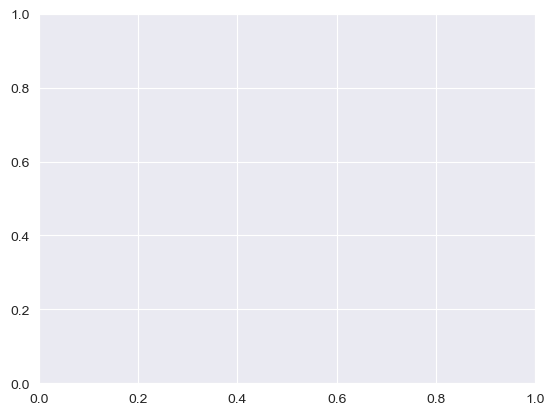

In [2]:
# =============================================================================
# EJEMPLO DE USO (Fuera de la clase, en tu script principal o Jupyter Notebook):
# =============================================================================
if __name__ == "__main__":
    # Ajusta la ruta al CSV y el nombre de la columna que será tu Y (ej. "adr", "children", etc.)
    ruta_csv = "hotel_bookings.csv"
    columna_objetivo = "adr"  # Ejemplo: predecir 'adr' (Average Daily Rate), cambia según tus necesidades

    proyecto = ProyectoRegresionLinealCSV(ruta_csv, columna_objetivo)

    # Ejecutar todo el pipeline
    proyecto.ejecutar_proyecto(
        epochs=200,
        alpha=0.001,
        imprimir_error_cada=20
    )